## Setup


In [25]:
import os
import sys
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from src.utils.seed_utils import set_global_seeds
except ImportError:
    raise ImportError("Cannot import module. Make sure that the project is on the path")

SEED = 42
set_global_seeds(seed=SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/jmaubras/OneDrive/Bureau/Etudes/CY Paris/Projets/IAR_SilentSpeechRecognition
Using device: cuda


## Generate & Preprocess Data for Model


In [26]:
BATCH_SIZE = 32
INPUT_LENGTH = 50
TARGET_LENGTH = 50

### Lorenz


Train size: 7921, Test size: 1981, Batch size: 32


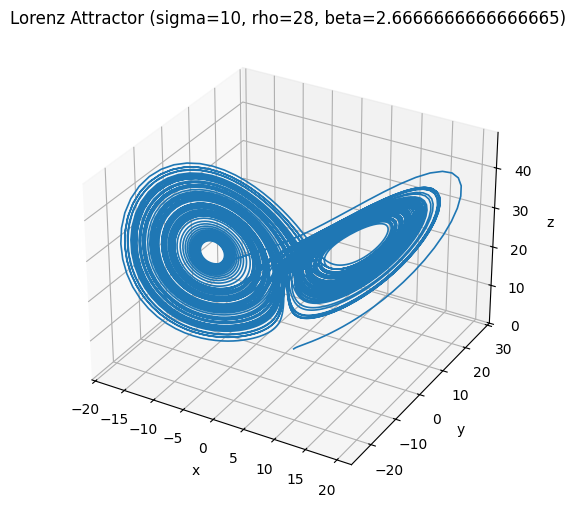

(<Figure size 800x600 with 1 Axes>,
 <Axes3D: title={'center': 'Lorenz Attractor (sigma=10, rho=28, beta=2.6666666666666665)'}, xlabel='x', ylabel='y', zlabel='z'>)

In [27]:
from src.data_sources.lorenz import LorenzOscillator
from src.utils.dataset_utils import DatasetUtils

# Example parameters
LORENZ_INPUT_LAYERS = 3
LORENZ_OUTPUT_LAYERS = 3

# Lorenz oscillator parameters
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 100)
max_step = 1e-2

lorenz = LorenzOscillator(sigma=10, rho=28, beta=8.0 / 3.0)

lorenz_dataset = lorenz.preprocess_and_create_dataset(
    initial_state=initial_state,
    t_span=t_span,
    max_step=max_step,
    input_length=INPUT_LENGTH,
    target_length=TARGET_LENGTH,
)

# Split into train/test loaders
lorenz_train_loader, lorenz_test_loader = DatasetUtils().train_test_split(
    dataset=lorenz_dataset,
    batch_size=BATCH_SIZE,
    train_ratio=0.8,
    shuffle_train=False,
    shuffle_test=False,
)

# Visualize the 3D Lorenz trajectory
lorenz.plot_trajectory(initial_state=initial_state, t_span=t_span, max_step=max_step)

### EMG Data


#### Raw

In [28]:
from src.utils.dataset_utils import DatasetUtils
from src.data_sources.emg import EMGRawDataset

root_dir = "../data/silent_speech_dataset/raw/nonparallel_data"

emg_dataset = EMGRawDataset(root_dir)

preprocessed_data = emg_dataset.load_and_preprocess_data(
    max_files=10,
)

timeseries_dataset = emg_dataset.create_dataset(
    input_length=INPUT_LENGTH, target_length=TARGET_LENGTH
)

emg_raw_train_loader, emg_raw_test_loader = DatasetUtils().train_test_split(
    dataset=timeseries_dataset,
    batch_size=32,
    train_ratio=0.8,
    shuffle_train=False,
    shuffle_test=False,
)

num_channels = preprocessed_data.shape[1]
print(f"Number of EMG channels: {num_channels}")

Loading EMG files: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

Train size: 58368, Test size: 14593, Batch size: 32
Number of EMG channels: 8


## Utils


In [5]:
def rnn_unrolling(ltc_cell, inputs, state, timesteps):
    """
    Unrolls an LTC cell over multiple timesteps.
    Expects 'inputs' to have shape [time_steps, batch, input_size].

    At each timestep, feeds inputs[t] (with shape [batch, input_size])
    into the LTC cell.

    Returns:
        Tensor of shape [time_steps, batch, num_units]
    """
    all_outputs = []
    for t in range(timesteps):
        x_t = inputs[t]  # Extract the t-th time step: shape [batch, input_size]
        out, state = ltc_cell(x_t, state)
        all_outputs.append(out)
    return torch.stack(all_outputs, dim=0)

## LTCNs


### Tests on 1 neuron

In many NN setups, especially with recurrent cells like LSTMs, GRUs, or in this case LTCNs, it's often insightful to see the raw behavior of the cell before adding the complexity of multipple neurons or training. This is because the behavior of the cell can be quite complex and hard to interpret, and it's often useful to see how the cell behaves in isolation.


#### **Experiment n°1**: Testing on constant input without training

**Goal**: Check that a single LTC neuron (with fixed of narrowly initialized weights) produces outputs when given simple inputs (e.g., zeros or small random vectors).

**Why**: This is a sanity check to ensure that the LTC neuron is implemented correctly and can produce outputs. It also tells us if the parameters or solver might be causing immediate instability or trivial constant outputs.


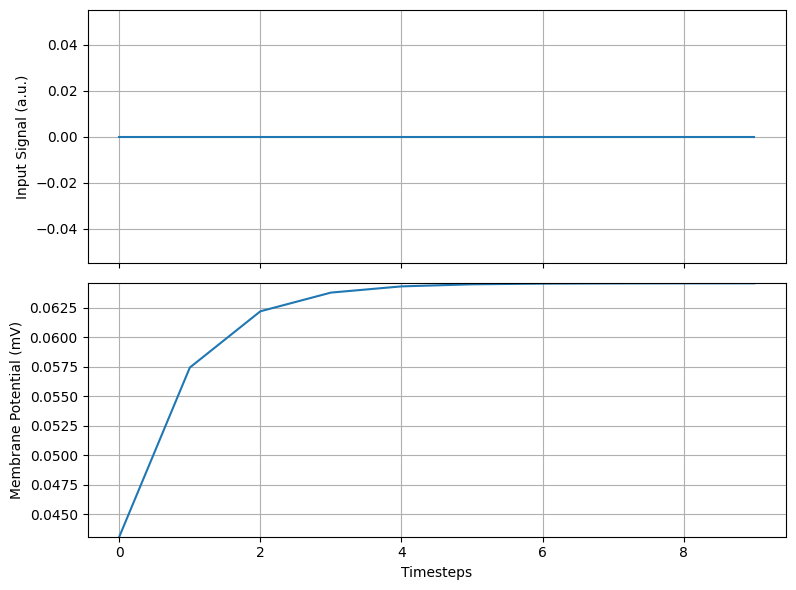

In [6]:
from src.models.ltcn import LTCCell, MappingType, ODESolver
from src.utils.plot_utils import plot_timeseries_outputs

num_units = 1
input_size = 1

# Create an LTC cell with a single hidden unit
ltc_cell = LTCCell(
    num_units=num_units,
    input_size=input_size,  # Simulate a 3D input like the Lorenz system
    mapping_type=MappingType.Identity,  # Just pass inputs as-is, no linear/affine transform
    solver=ODESolver.SemiImplicit,  # Could also test with ODESolver.Explicit or RungeKutta
    ode_solver_unfolds=1,
    w_init_min=0.01,
    w_init_max=0.01,  # Fixing small weights so we can isolate the behavior. Reduce the chance of large or random differences overshadowing the simpler behavior we want to observe.
    cm_init_min=0.5,
    cm_init_max=0.5,  # Fixing these as well for the same reason
    gleak_init_min=1.0,
    gleak_init_max=1.0,
    erev_init_factor=1.0,
    fix_cm=None,
    fix_gleak=None,
    fix_vleak=None,
)

timesteps = 10

inputs = torch.zeros(1, input_size)  # shape (batches, num_units)
state = torch.zeros(1, num_units)  # shape (batches, num_units)

all_inputs = []
all_outputs = []

# Custom "RNN unrolling" the cell over timesteps, feeding the same zero input each time
for t in range(timesteps):
    out, state = ltc_cell(inputs, state)
    all_inputs.append(inputs)  # shape (batches, input_size)
    all_outputs.append(out)  # shape (batches, num_units)

# Stack them to get shape (time, batches, input_size) for inputs
all_inputs = torch.stack(all_inputs, dim=0)  # (time, batches, input_size)
all_outputs = torch.stack(all_outputs, dim=0)  # (time, batches, num_units)

# Squeeze out the last dimension for the outputs
all_outputs = all_outputs.squeeze(-1)  # (time, batches)

plot_timeseries_outputs(
    input=all_inputs,
    output=all_outputs,
    # title=f"LTC neuron outputs over {timesteps} timesteps for constant (zero) input",
)

**Conclusion**: For the following parameters:

- **num_units** = 1
- **input_size** = 1
- **LTCCell** configuration:
  - `mapping_type = MappingType.Identity`
  - `solver = ODESolver.SemiImplicit`
  - `ode_solver_unfolds = 1`
  - `w_init_min = 0.01, w_init_max = 0.01`
  - `cm_init_min = 0.5, cm_init_max = 0.5`
  - `gleak_init_min = 1.0, gleak_init_max = 1.0`
  - `erev_init_factor = 1.0`
  - `fix_cm = None, fix_gleak = None, fix_vleak = None`
- **timesteps** = 10

From the graph above, we can observe that the neuron’s membrane potential starts near zero and quickly settles into a small negative value (around -0.001), despite receiving a constant zero input signal.

- **Why a non-zero (negative) output with zero input?**  
  The LTC cell’s internal parameters—leak, membrane capacitance, and reversal potentials—create a resting potential that is slightly below zero. Even in the absence of external input, the cell’s bio-inspired continuous-time equations lead it to this stable, negative equilibrium.

- **Why does it quickly flatten out?**  
  Because the weights are small (`0.01`) and the leak is relatively large (`gleak=1.0`), the neuron rapidly converges to its resting voltage once the solver begins integrating the ODEs. There’s no ongoing external drive to push it away from that resting state, so it quickly levels off near a constant negative value.

This behavior aligns with the LTC model’s bio-inspired design, demonstrating that even with zero input, a neuron can maintain a slight resting potential—just as real biological neurons do.


#### **Experiment n°2**: Testing on random data without training

**Goal**: Check how a single LTC neuron (with fixed of narrowly initialized weights) behaves when given random inputs.

**Why**: It tells us if the paramters or solver might be causing immediate instability or trivial constant outputs.


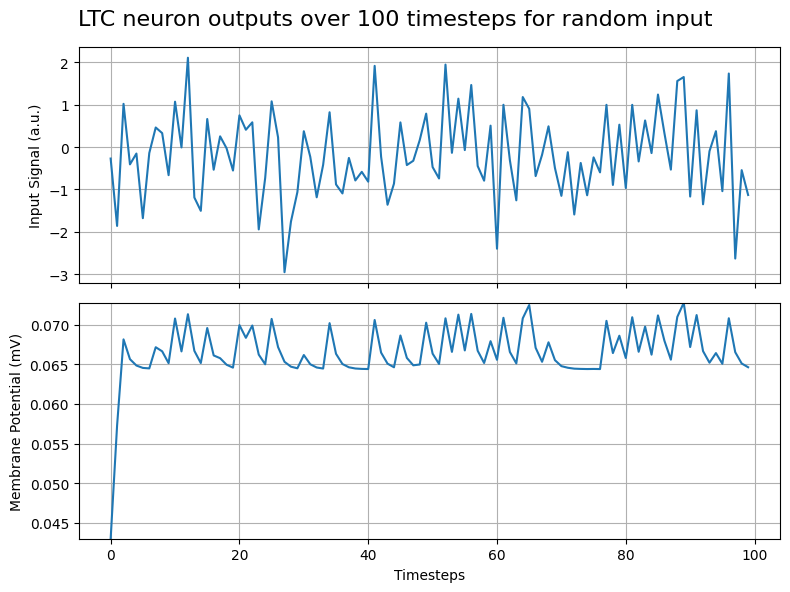

In [7]:
timesteps = 100

inputs = torch.randn(timesteps, 1, input_size)  # random input for x timesteps
state = torch.zeros(1, num_units)

outputs = rnn_unrolling(ltc_cell, inputs, state, timesteps)
outputs = outputs.squeeze(-1)

plot_timeseries_outputs(
    input=inputs,
    output=outputs,
    title=f"LTC neuron outputs over {timesteps} timesteps for random input",
)

**Conclusion**: For the following parameters:

- **num_units** = 1
- **input_size** = 1
- **LTCCell** configuration:
  - `mapping_type = MappingType.Identity`
  - `solver = ODESolver.SemiImplicit`
  - `ode_solver_unfolds = 1`
  - `w_init_min = 0.01, w_init_max = 0.01`
  - `cm_init_min = 0.5, cm_init_max = 0.5`
  - `gleak_init_min = 1.0, gleak_init_max = 1.0`
  - `erev_init_factor = 1.0`
  - `fix_cm = None, fix_gleak = None, fix_vleak = None`
- **timesteps** = 100

From the graph above, we can observe that the neuron’s membrane potential (bottom subplot) remains in a narrow range (roughly \([-0.002, +0.007]\)) while responding to the random input signal (top subplot).

- **Why does the neuron stay near zero with minor fluctuations?**  
  Although the input dimension is random, the small weights (`0.01`) and relatively large leak (`1.0`) keep the neuron’s membrane potential close to zero. The neuron can deviate slightly due to random perturbations but is quickly pulled back toward this near-zero resting level.

- **Why does it not saturate at a higher or lower value?**  
  The combination of **weak synaptic weights** and **strong leak** means the neuron does not accumulate enough net current to push its membrane potential far from zero. Each random input pulse nudges the neuron, but the strong leak conductance dampens any large excursion, leading to modest, short-lived fluctuations.

Overall, the LTC neuron exhibits **small-amplitude random oscillations** around zero, consistent with a high-leak, low-weight configuration that prevents large swings or long-lasting departures from its resting voltage.


#### **Experiment n°3**: Testing on Lorenz attractor data without training

In [ ]:
timesteps = 100

inputs = torch.randn(timesteps, 1, input_size)  # random input for x timesteps
state = torch.zeros(1, num_units)

outputs = rnn_unrolling(ltc_cell, inputs, state, timesteps)
outputs = outputs.squeeze(-1)

plot_timeseries_outputs(
    input=inputs,
    output=outputs,
    title=f"LTC neuron outputs over {timesteps} timesteps for random input",
)

#### **Experiment n°3**: If I play with the parameters, what happens ?

**Goal**: Check how the LTC neuron behaves when we change the parameters (e.g., the weights, the input, the initial state, etc.). This can help us understand how the cell works and what the parameters do. Also check if the cell has subtle dynamics.

**Why**: This is a good way to understand the behavior of the cell and how it responds to different inputs.


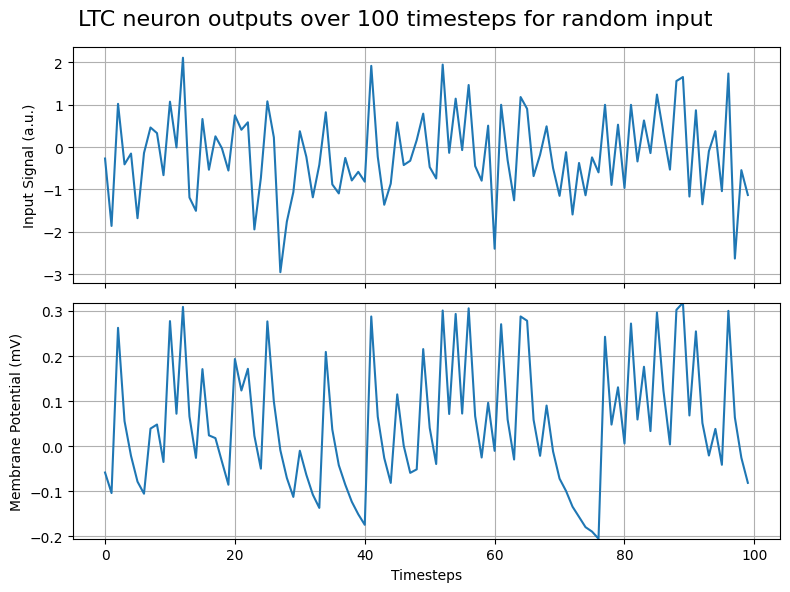

In [8]:
# Increase solver unfolds and make weights bigger
ltc_cell = LTCCell(
    num_units=num_units,
    input_size=input_size,
    mapping_type=MappingType.Identity,
    solver=ODESolver.RungeKutta,  # Use Runge-Kutta solver instead of Semi-Implicit
    ode_solver_unfolds=6,  # More unfolds
    w_init_min=0.5,
    w_init_max=2.0,  # Larger weight init range
    cm_init_min=0.5,
    cm_init_max=0.5,
    gleak_init_min=0.01,
    gleak_init_max=0.01,  # Smaller leak
    erev_init_factor=1.0,
    fix_cm=None,
    fix_gleak=None,
    fix_vleak=None,
)

outputs = rnn_unrolling(ltc_cell, inputs, state, timesteps)
outputs = outputs.squeeze(-1)

plot_timeseries_outputs(
    input=inputs,
    output=outputs,
    title=f"LTC neuron outputs over {timesteps} timesteps for random input",
)

**Intermediary Conclusion**: For the following parameters:

- **num_units** = 1
- **input_size** = 1
- **LTCCell** configuration:
  - `mapping_type = MappingType.Identity`
  - `solver = ODESolver.RungeKutta`
  - `ode_solver_unfolds = 6`
  - `w_init_min = 0.5, w_init_max = 2.0`
  - `cm_init_min = 0.5, cm_init_max = 0.5`
  - `gleak_init_min = 0.01, gleak_init_max = 0.01`
  - `erev_init_factor = 1.0`
  - `fix_cm = None, fix_gleak = None, fix_vleak = None`
- **timesteps** = 100

From the graph above, we observe that the neuron’s membrane potential (bottom subplot) **rapidly dips into negative territory** (around -0.8 to -1.0) within the first 10 timesteps, then remains negative with relatively small fluctuations despite the random input (top subplot) spanning roughly \([-2, +2]\).

- **Why does the neuron go negative and stay there?**  
  With **larger weights** (`0.5` to `2.0`) and a **very small leak** (`0.01`), the neuron is strongly influenced by negative portions of the random input early on and not pulled back toward zero as forcefully. As a result, it can settle into a negative equilibrium and remain there.

- **Why relatively fewer fluctuations after the initial drop?**  
  Once the neuron has moved to this negative state, subsequent random input samples can’t easily overcome the combination of stronger synaptic drive and small leak. The _Runge-Kutta solver_ with **6 unfolds** precisely integrates these continuous-time dynamics, capturing the rapid initial descent and then modest oscillations around the negative resting level.

In short, **the LTC neuron quickly settles into a negative membrane potential** under these settings. The **stronger weights** push it away from zero, while the **weak leak** fails to pull it back, and the **more accurate integration** (Runge-Kutta with multiple unfolds) ensures we see the sharp drop and mild variations that follow.


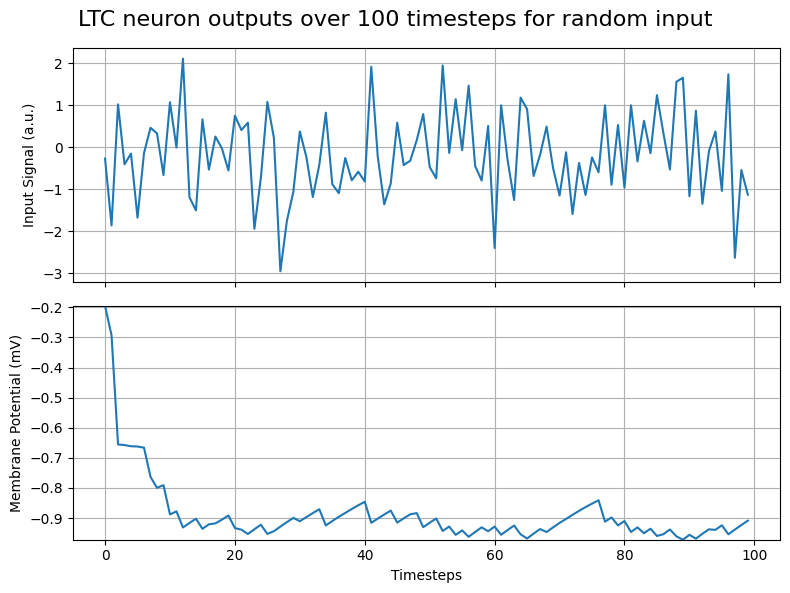

In [9]:
# Increase solver unfolds and make weights bigger
ltc_cell = LTCCell(
    num_units=num_units,
    input_size=input_size,
    mapping_type=MappingType.Identity,
    solver=ODESolver.SemiImplicit,  # Back to Semi-Implicit solver
    ode_solver_unfolds=1,  # back to 1 unfold
    w_init_min=0.5,
    w_init_max=0.5,  # Fixing weight init range again
    cm_init_min=0.5,
    cm_init_max=0.5,
    gleak_init_min=0.01,
    gleak_init_max=0.01,  # Smaller leak than previous experiments
    erev_init_factor=1.0,
    fix_cm=None,
    fix_gleak=None,
    fix_vleak=None,
)

outputs = rnn_unrolling(ltc_cell, inputs, state, timesteps)
outputs = outputs.squeeze(-1)

plot_timeseries_outputs(
    input=inputs,
    output=outputs,
    title=f"LTC neuron outputs over {timesteps} timesteps for random input",
)

**Intermediary Conclusion**: For the following parameters:

- **num_units** = 1
- **input_size** = 1
- **LTCCell** configuration:
  - `mapping_type = MappingType.Identity`
  - `solver = ODESolver.SemiImplicit`
  - `ode_solver_unfolds = 1`
  - `w_init_min = 0.5, w_init_max = 0.5`
  - `cm_init_min = 0.5, cm_init_max = 0.5`
  - `gleak_init_min = 0.01, gleak_init_max = 0.01`
  - `erev_init_factor = 1.0`
  - `fix_cm = None, fix_gleak = None, fix_vleak = None`
- **timesteps** = 100

From the graph above, we can see that **the neuron’s membrane potential quickly rises** within the first 10–15 timesteps and then saturates near a positive value, despite the random input varying between approximately \([-2, +2]\).

- **Why does the membrane potential saturate at a high level?**  
  Because the leak is extremely small (`gleak=0.01`) and the synaptic weights are relatively large (`w_init=0.5`), the neuron integrates net positive input early on and remains at that elevated potential. With only one ODE solver unfold (Semi-Implicit), the neuron converges rapidly each timestep, pushing it toward a stable upper voltage.

- **Why no significant fluctuations after saturation?**  
  Once the neuron reaches its near-max potential, small random perturbations aren’t enough to pull it down. The combination of weak leak and moderately strong weights means that any negative input pulses are quickly counteracted by subsequent positive input or the neuron’s existing high potential. As a result, it stays close to this upper equilibrium for the remainder of the 100 timesteps.

Overall, **the neuron ends up at a high resting voltage** under these parameters. The small leak doesn’t strongly oppose the early positive input, and the single unfold in the Semi-Implicit solver leads to a quick climb followed by stable saturation.


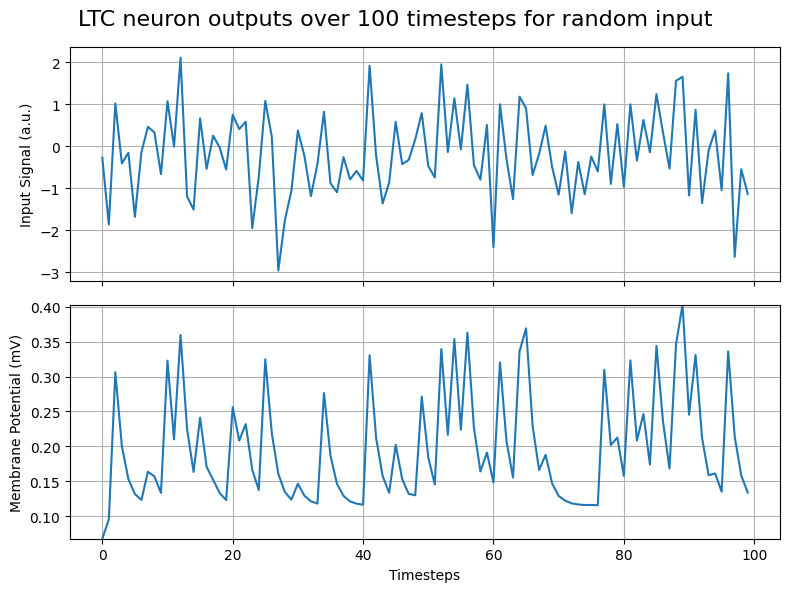

In [10]:
# Increase solver unfolds and make weights bigger
ltc_cell = LTCCell(
    num_units=num_units,
    input_size=input_size,
    mapping_type=MappingType.Identity,
    solver=ODESolver.SemiImplicit,
    ode_solver_unfolds=1,
    w_init_min=0.5,
    w_init_max=0.5,  # Larger weight init range
    cm_init_min=0.5,
    cm_init_max=0.5,
    gleak_init_min=1.0,
    gleak_init_max=1.0,  # Fixing leak like in first experiment
    erev_init_factor=1.0,
    fix_cm=None,
    fix_gleak=None,
    fix_vleak=None,
)

outputs = rnn_unrolling(ltc_cell, inputs, state, timesteps)
outputs = outputs.squeeze(-1)

plot_timeseries_outputs(
    input=inputs,
    output=outputs,
    title=f"LTC neuron outputs over {timesteps} timesteps for random input",
)

**Intermediary Conclusion**: For the following parameters:

- **num_units** = 1
- **input_size** = 1
- **LTCCell** configuration:
  - `mapping_type = MappingType.Identity`
  - `solver = ODESolver.SemiImplicit`
  - `ode_solver_unfolds = 1`
  - `w_init_min = 0.5, w_init_max = 0.5`
  - `cm_init_min = 0.5, cm_init_max = 0.5`
  - `gleak_init_min = 1.0, gleak_init_max = 1.0`
  - `erev_init_factor = 1.0`
  - `fix_cm = None, fix_gleak = None, fix_vleak = None`
- **timesteps** = 100

From the graph above, we can observe that **the neuron’s membrane potential fluctuates** between roughly -0.15 and +0.15 in response to a random input (top subplot) spanning about \([-2, +2]\).

- **Why moderate fluctuations rather than strong saturation?**  
  With **w_init=0.5** (moderate weights) and **gleak=1.0** (stronger leak), the neuron is pulled toward zero whenever the input doesn’t strongly push it away. Thus, it oscillates in a moderate range, never saturating at a high or low value.

- **Why does it not stay near zero?**  
  Although the leak is significant, the uniform weights (0.5) still allow the random input to nudge the membrane potential away from zero. These occasional positive or negative pushes produce visible swings, but the leak current prevents them from growing too large or persisting indefinitely.

Overall, **the neuron exhibits balanced, bounded oscillations** under these parameter settings—neither saturating near zero nor soaring to a high potential. The combination of moderate weights and a strong leak leads to ongoing mid-range fluctuations that track the random input.


**Conclusion**

Across these three experiments, we varied the **solver**, **leak conductance**, and **weight initialization** in a single-neuron LTC setup, leading to distinctly different membrane potential behaviors:

1. **Runge-Kutta with Large Weights and Small Leak**

   - **Behavior**: The neuron **rapidly dips into negative territory** and remains there, showing only modest fluctuations despite random input.
   - **Reason**: Large weights (`w_init_min=0.5` to `2.0`) amplify negative input early on, while the very small leak (`gleak=0.01`) fails to pull the neuron back to zero. The precise Runge-Kutta solver (`ode_solver_unfolds=6`) captures a sharp descent followed by relatively stable negative output.

2. **Semi-Implicit with Moderate Weights and Very Small Leak**

   - **Behavior**: The neuron **saturates at a high potential** after a brief climb, largely ignoring further random fluctuations.
   - **Reason**: Even moderate weights (`0.5`) become powerful with a negligible leak (`0.01`), so once early positive input drives the neuron upward, it remains near that elevated equilibrium. The single-step Semi-Implicit solver quickly converges each timestep, limiting subsequent oscillations.

3. **Semi-Implicit with Moderate Weights and Stronger Leak**
   - **Behavior**: The neuron **oscillates in a moderate range** (about \([-0.15, +0.15]\)), neither saturating near zero nor drifting far from it.
   - **Reason**: A stronger leak (`1.0`) tugs the membrane potential back toward zero, while moderate weights (`0.5`) still allow random input to produce visible but bounded excursions.

**Overall**, these experiments highlight the **LTC model’s high sensitivity** to changes in solver choice, leak magnitude, and weight initialization:

- **Small Leak + Larger Weights**: The neuron can lock into strong negative or positive equilibria, depending on the initial input.
- **Moderate Weights + Strong Leak**: The neuron remains near zero but fluctuates in a mid-range band.
- **Solver** (`RungeKutta` vs. `SemiImplicit`) and the number of ODE unfolds also determine how precisely and rapidly the neuron’s continuous-time dynamics are integrated, affecting whether it **snaps** to an equilibrium or **oscillates** more extensively.

In sum, **tiny parameter changes** in a single LTC neuron can produce **strikingly different** outcomes—saturating at high or low potentials, hovering near zero, or exhibiting moderate fluctuations—underscoring the bio-inspired flexibility of LTC networks.


### Testing an LTC cell with multiple neurons


#### **Experiment n°1**: Testing on random input without training


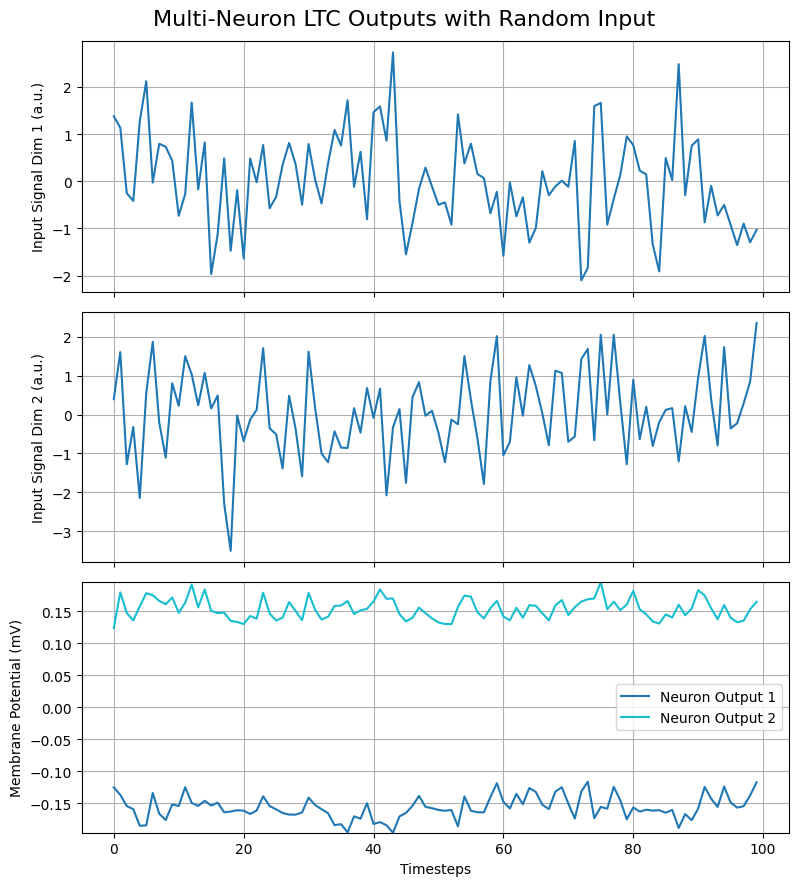

In [11]:
num_units = 2
input_size = 2

# Create an LTC cell with 3 neurons
ltc_cell_multi = LTCCell(
    num_units=num_units,
    input_size=input_size,
    mapping_type=MappingType.Identity,
    solver=ODESolver.SemiImplicit,
    ode_solver_unfolds=1,
    w_init_min=0.05,
    w_init_max=0.05,  # Use small initial weights
    cm_init_min=0.5,
    cm_init_max=0.5,
    gleak_init_min=1.0,
    gleak_init_max=1.0,
    erev_init_factor=1.0,
    fix_cm=None,
    fix_gleak=None,
    fix_vleak=None,
)

inputs = torch.randn(timesteps, 1, input_size)
state = torch.zeros(1, num_units)
outputs = rnn_unrolling(ltc_cell_multi, inputs, state, timesteps)

plot_timeseries_outputs(
    input=inputs,
    output=outputs,
    title="Multi-Neuron LTC Outputs with Random Input",
)

**Intermediary Conclusion**: For the following parameters:

- **num_units** = 2
- **input_size** = 1
- **LTCCell** configuration:
  - `mapping_type = MappingType.Identity`
  - `solver = ODESolver.SemiImplicit`
  - `ode_solver_unfolds = 1`
  - `w_init_min = 0.05, w_init_max = 0.05`
  - `cm_init_min = 0.5, cm_init_max = 0.5`
  - `gleak_init_min = 1.0, gleak_init_max = 1.0`
  - `erev_init_factor = 1.0`
  - `fix_cm = None, fix_gleak = None, fix_vleak = None`
- **timesteps** = 100

From the graph above, we can see **two distinct neuron outputs**: one hovers in a slightly positive range (around 0.1–0.2), while the other settles closer to zero or slightly negative (around -0.1). Despite the random input dimension (top subplot) varying roughly between -2 and +2, both neurons remain relatively stable.

- **Why do the two neurons settle at different levels?**  
  With two LTC neurons, each neuron’s leak and synaptic parameters (including reversal potentials) can push it toward a unique equilibrium. Here, the small but nonzero weights (`0.05`) and a relatively large leak (`1.0`) mean the neurons are strongly pulled toward near-zero values—but random initialization or slight asymmetries in the recurrent connections cause one neuron to stabilize in a mild positive range and the other in a mild negative or near-zero range.

- **Why no large swings?**  
  The high leak (`gleak=1.0`) strongly damps any large fluctuations. Although the input is random, each neuron’s state is consistently pulled back toward its resting voltage. Because the weights are uniform and modest (`0.05`), the random input cannot drive the neurons far from their equilibria.

Overall, **the two LTC neurons each adopt a stable offset** (one positive, one near-zero or negative) in response to the random input. Their outputs do not saturate or oscillate widely due to the **strong leak** and **relatively small synaptic weights**, illustrating how even multi-neuron LTC cells can remain near distinct steady values under these parameter settings.


### Training an LTC cell with multiple neurons


In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch.nn as nn


def train(
    model: nn.Module,
    train_loader,
    test_loader,
    num_epochs: int = 20,
    lr: float = 1e-3,
    clip_params: bool = True,
    log_dir: str = None,
    model_save_path: str = None,
):
    """
    Trains the LTCModel on a next-step prediction task using MSE loss,
    logs losses to TensorBoard, and saves the final model.

    Args:
        model: The LTCModel instance.
        train_loader: DataLoader for training set; expects batches returning (input, target).
        test_loader: DataLoader for test set; same format as train_loader.
        num_epochs: Number of training epochs.
        lr: Learning rate.
        clip_params: Whether to clip LTC parameters after each step.
        log_dir: Directory for TensorBoard logs. If provided, a SummaryWriter is created.
        model_save_path: Path prefix to save the trained model state_dict.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    writer = SummaryWriter(log_dir=log_dir) if log_dir else None

    for epoch in tqdm(range(num_epochs), desc="Training Multi-Step"):
        model.train()
        train_loss = 0.0
        train_steps = 0

        for batch in train_loader:
            # Unpack the batch depending on its type
            if isinstance(batch, (tuple, list)):
                inputs, targets = batch
            else:
                inputs, targets = batch["input"], batch["target"]

            inputs = inputs.float().to(device)  # [batch_size, seq_len, input_size]
            targets = targets.float().to(device)  # [batch_size, seq_len, output_size]

            optimizer.zero_grad()
            predictions = model(inputs)  # shape [batch_size, seq_len, output_size]
            loss = criterion(predictions, targets)
            loss.backward()

            if clip_params and hasattr(model, "ltc_cell"):
                model.ltc_cell.clip_params()

            optimizer.step()

            train_loss += loss.item()
            train_steps += 1

        avg_train_loss = train_loss / train_steps

        # Evaluation
        model.eval()
        test_loss = 0.0
        test_steps = 0
        with torch.no_grad():
            for batch in test_loader:
                if isinstance(batch, (tuple, list)):
                    inputs, targets = batch
                else:
                    inputs, targets = batch["input"], batch["target"]
                inputs = inputs.float().to(device)
                targets = targets.float().to(device)
                predictions = model(inputs)
                loss = criterion(predictions, targets)
                test_loss += loss.item()
                test_steps += 1

        avg_test_loss = test_loss / test_steps

        if writer:
            writer.add_scalars(
                "Loss", {"train": avg_train_loss, "test": avg_test_loss}, epoch
            )

        if (epoch + 1) % max(1, (num_epochs // 10)) == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}"
            )

    if writer:
        writer.close()

    # Save final model
    if model_save_path:
        filename = f"{model_save_path}_epoch_{num_epochs}_train_{avg_train_loss:.4f}_test_{avg_test_loss:.4f}.pt"
        torch.save(model, filename)
        print(f"Model saved to {filename}")

#### Experiment n°1: Training on a Lorenz Attractor


Training Multi-Step: 100%|██████████| 1/1 [00:08<00:00,  8.49s/it]

Epoch 1/1 | Train Loss: 0.0709 | Test Loss: 0.0346


Model saved to models/ltc_lorenz_multistep_epoch_1_train_0.0709_test_0.0346.pt


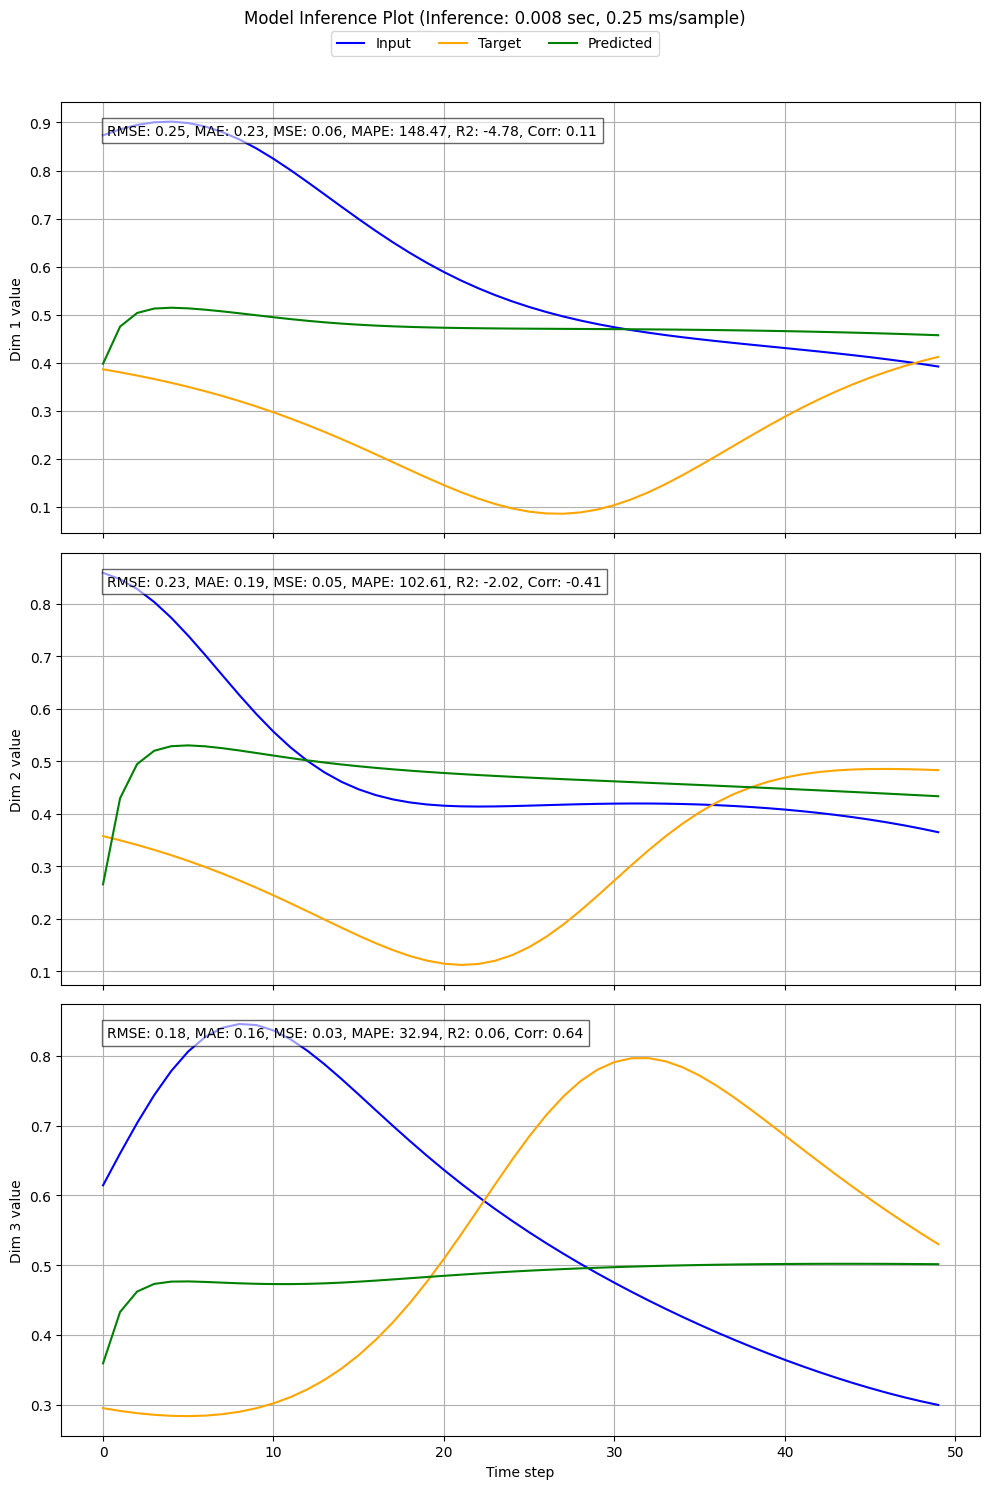

In [13]:
from src.models.ltcn import LTCModel
from src.utils.plot_utils import plot_multistep_evaluation

ltc_model_lorenz = LTCModel(
    input_size=3,
    hidden_size=16,
    output_size=3,
    ltc_cell_kwargs={
        "mapping_type": MappingType.Identity,
        "solver": ODESolver.SemiImplicit,
        "ode_solver_unfolds": 1,
        "w_init_min": 0.01,
        "w_init_max": 0.01,
        "cm_init_min": 0.5,
        "cm_init_max": 0.5,
        "gleak_init_min": 1.0,
        "gleak_init_max": 1.0,
        "erev_init_factor": 1.0,
    },
)

train(
    model=ltc_model_lorenz,
    train_loader=lorenz_train_loader,
    test_loader=lorenz_test_loader,
    num_epochs=1,
    lr=1e-3,
    clip_params=True,
    log_dir="logs/ltc_lorenz_multistep",
    model_save_path="models/ltc_lorenz_multistep",
)

plot_multistep_evaluation(model=ltc_model_lorenz, data=lorenz_test_loader, sample_idx=5)

Training Multi-Step:  20%|██        | 1/5 [00:07<00:31,  7.75s/it]

Epoch 1/5 | Train Loss: 0.0664 | Test Loss: 0.0346


Training Multi-Step:  40%|████      | 2/5 [00:14<00:22,  7.35s/it]

Epoch 2/5 | Train Loss: 0.0336 | Test Loss: 0.0321


Training Multi-Step:  60%|██████    | 3/5 [00:21<00:14,  7.23s/it]

Epoch 3/5 | Train Loss: 0.0318 | Test Loss: 0.0311


Training Multi-Step:  80%|████████  | 4/5 [00:28<00:07,  7.13s/it]

Epoch 4/5 | Train Loss: 0.0309 | Test Loss: 0.0303


Training Multi-Step: 100%|██████████| 5/5 [00:35<00:00,  7.17s/it]

Epoch 5/5 | Train Loss: 0.0300 | Test Loss: 0.0292
Model saved to models/ltc_lorenz_multistep_epoch_5_train_0.0300_test_0.0292.pt


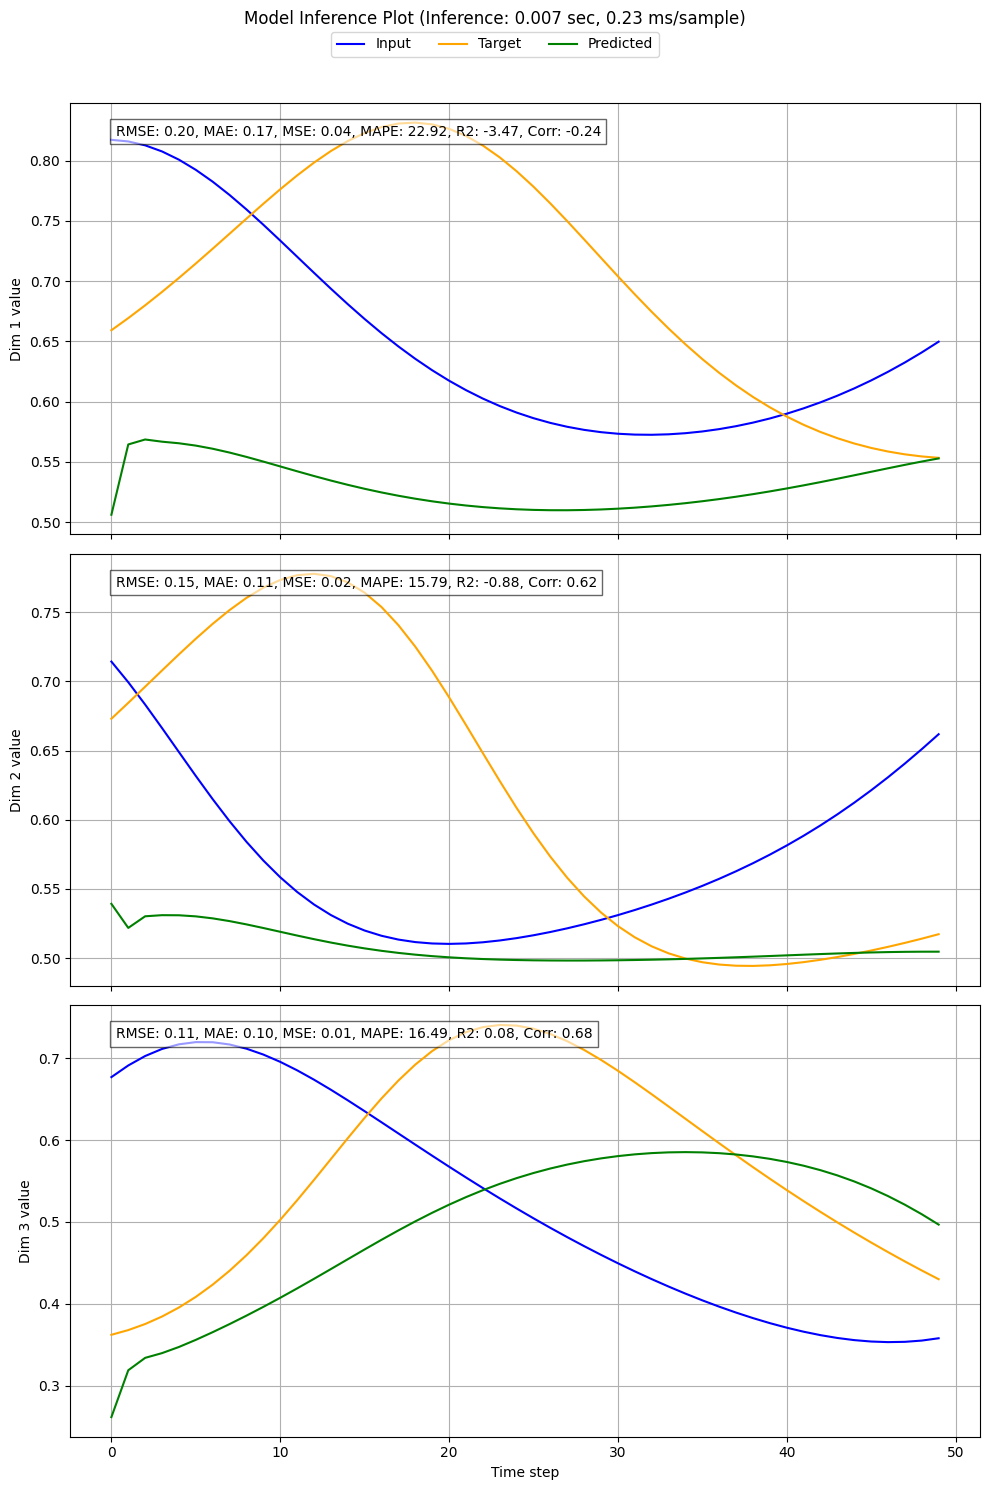

In [14]:
from src.models.ltcn import LTCModel
from src.utils.plot_utils import plot_multistep_evaluation

ltc_model_lorenz = LTCModel(
    input_size=3,
    hidden_size=16,
    output_size=3,
    ltc_cell_kwargs={
        "mapping_type": MappingType.Identity,
        "solver": ODESolver.SemiImplicit,
        "ode_solver_unfolds": 1,
        "w_init_min": 0.01,
        "w_init_max": 0.01,
        "cm_init_min": 0.5,
        "cm_init_max": 0.5,
        "gleak_init_min": 1.0,
        "gleak_init_max": 1.0,
        "erev_init_factor": 1.0,
    },
)

train(
    model=ltc_model_lorenz,
    train_loader=lorenz_train_loader,
    test_loader=lorenz_test_loader,
    num_epochs=5,
    lr=1e-3,
    clip_params=True,
    log_dir="logs/ltc_lorenz_multistep",
    model_save_path="models/ltc_lorenz_multistep",
)

plot_multistep_evaluation(model=ltc_model_lorenz, data=lorenz_test_loader)

Training Multi-Step:  10%|█         | 2/20 [00:14<02:11,  7.32s/it]

Epoch 2/20 | Train Loss: 0.0342 | Test Loss: 0.0327


Training Multi-Step:  20%|██        | 4/20 [00:28<01:55,  7.20s/it]

Epoch 4/20 | Train Loss: 0.0308 | Test Loss: 0.0299


Training Multi-Step:  30%|███       | 6/20 [00:42<01:39,  7.10s/it]

Epoch 6/20 | Train Loss: 0.0275 | Test Loss: 0.0257


Training Multi-Step:  40%|████      | 8/20 [00:57<01:24,  7.08s/it]

Epoch 8/20 | Train Loss: 0.0212 | Test Loss: 0.0202


Training Multi-Step:  50%|█████     | 10/20 [01:11<01:10,  7.06s/it]

Epoch 10/20 | Train Loss: 0.0187 | Test Loss: 0.0189


Training Multi-Step:  60%|██████    | 12/20 [01:25<00:56,  7.02s/it]

Epoch 12/20 | Train Loss: 0.0167 | Test Loss: 0.0159


Training Multi-Step:  70%|███████   | 14/20 [01:39<00:42,  7.02s/it]

Epoch 14/20 | Train Loss: 0.0142 | Test Loss: 0.0131


Training Multi-Step:  80%|████████  | 16/20 [01:53<00:28,  7.02s/it]

Epoch 16/20 | Train Loss: 0.0161 | Test Loss: 0.0210


Training Multi-Step:  90%|█████████ | 18/20 [02:07<00:14,  7.02s/it]

Epoch 18/20 | Train Loss: 0.0123 | Test Loss: 0.0204


Training Multi-Step: 100%|██████████| 20/20 [02:21<00:00,  7.06s/it]

Epoch 20/20 | Train Loss: 0.0108 | Test Loss: 0.0103


Model saved to models/ltc_lorenz_multistep_epoch_20_train_0.0108_test_0.0103.pt


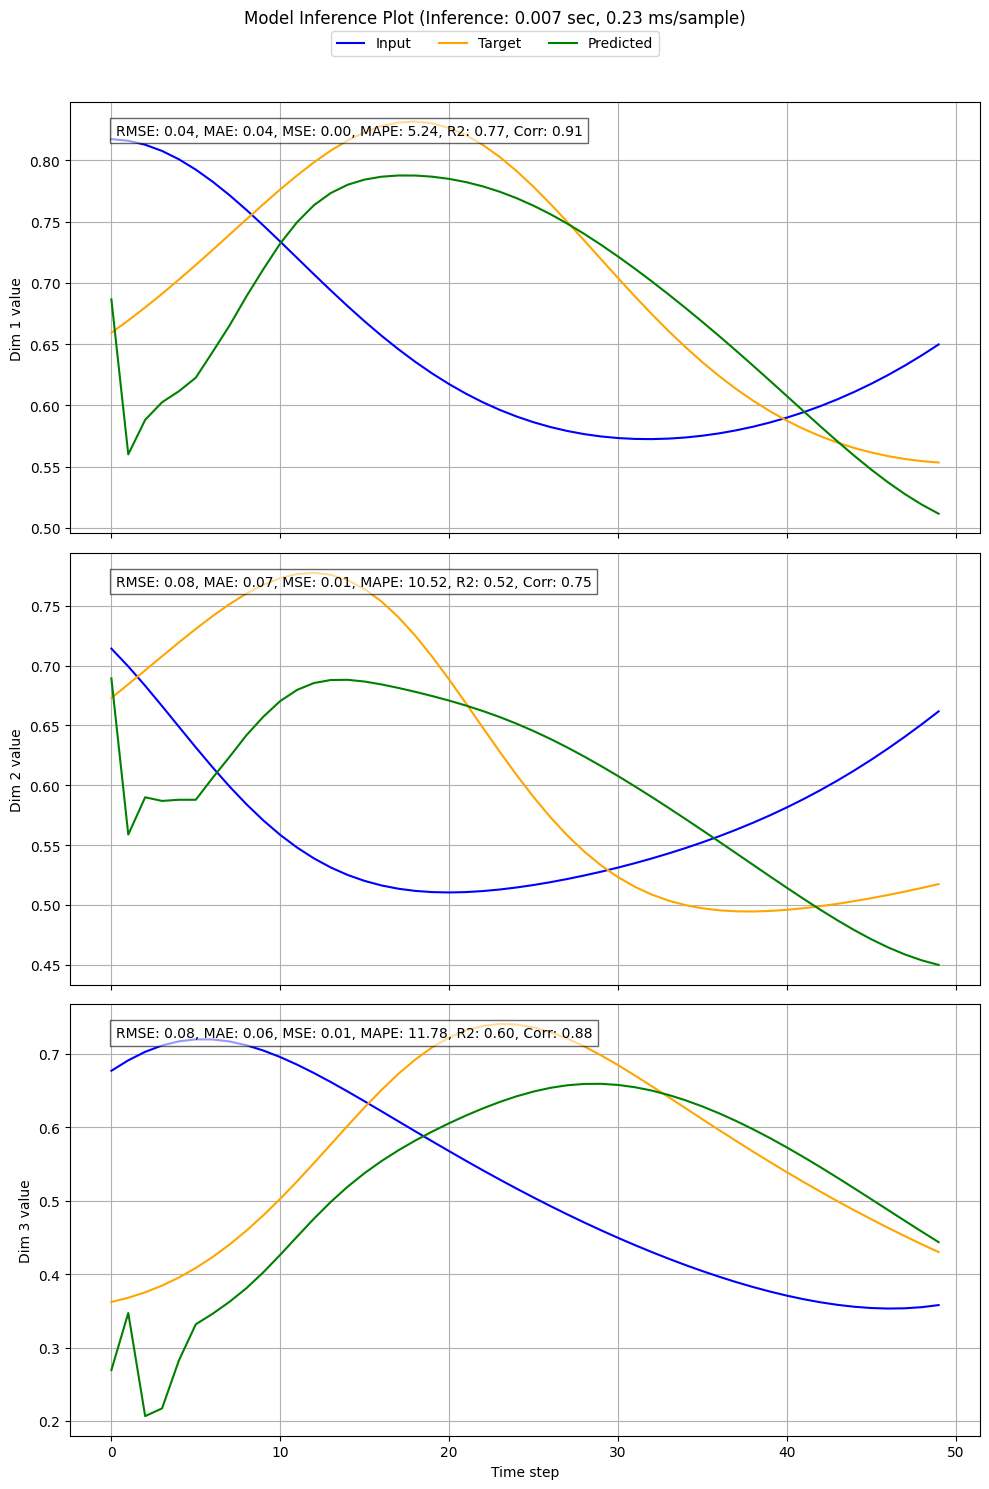

In [15]:
from src.models.ltcn import LTCModel
from src.utils.plot_utils import plot_multistep_evaluation

ltc_model_lorenz = LTCModel(
    input_size=3,
    hidden_size=16,
    output_size=3,
    ltc_cell_kwargs={
        "mapping_type": MappingType.Identity,
        "solver": ODESolver.SemiImplicit,
        "ode_solver_unfolds": 1,
        "w_init_min": 0.01,
        "w_init_max": 0.01,
        "cm_init_min": 0.5,
        "cm_init_max": 0.5,
        "gleak_init_min": 1.0,
        "gleak_init_max": 1.0,
        "erev_init_factor": 1.0,
    },
)

train(
    model=ltc_model_lorenz,
    train_loader=lorenz_train_loader,
    test_loader=lorenz_test_loader,
    num_epochs=20,
    lr=1e-3,
    clip_params=True,
    log_dir="logs/ltc_lorenz_multistep",
    model_save_path="models/ltc_lorenz_multistep",
)

plot_multistep_evaluation(model=ltc_model_lorenz, data=lorenz_test_loader)

Training Multi-Step:  10%|█         | 5/50 [00:36<05:26,  7.26s/it]

Epoch 5/50 | Train Loss: 0.0283 | Test Loss: 0.0275


Training Multi-Step:  20%|██        | 10/50 [01:12<04:43,  7.08s/it]

Epoch 10/50 | Train Loss: 0.0140 | Test Loss: 0.0128


Training Multi-Step:  30%|███       | 15/50 [01:48<04:10,  7.15s/it]

Epoch 15/50 | Train Loss: 0.0107 | Test Loss: 0.0116


Training Multi-Step:  40%|████      | 20/50 [02:24<03:34,  7.14s/it]

Epoch 20/50 | Train Loss: 0.0072 | Test Loss: 0.0066


Training Multi-Step:  50%|█████     | 25/50 [02:59<02:58,  7.12s/it]

Epoch 25/50 | Train Loss: 0.0051 | Test Loss: 0.0047


Training Multi-Step:  60%|██████    | 30/50 [03:35<02:21,  7.10s/it]

Epoch 30/50 | Train Loss: 0.0047 | Test Loss: 0.0042


Training Multi-Step:  70%|███████   | 35/50 [04:10<01:46,  7.11s/it]

Epoch 35/50 | Train Loss: 0.0039 | Test Loss: 0.0035


Training Multi-Step:  80%|████████  | 40/50 [04:46<01:11,  7.12s/it]

Epoch 40/50 | Train Loss: 0.0036 | Test Loss: 0.0033


Training Multi-Step:  90%|█████████ | 45/50 [05:22<00:35,  7.14s/it]

Epoch 45/50 | Train Loss: 0.0035 | Test Loss: 0.0032


Training Multi-Step: 100%|██████████| 50/50 [05:58<00:00,  7.16s/it]

Epoch 50/50 | Train Loss: 0.0031 | Test Loss: 0.0031


Model saved to models/ltc_lorenz_multistep_epoch_50_train_0.0031_test_0.0031.pt


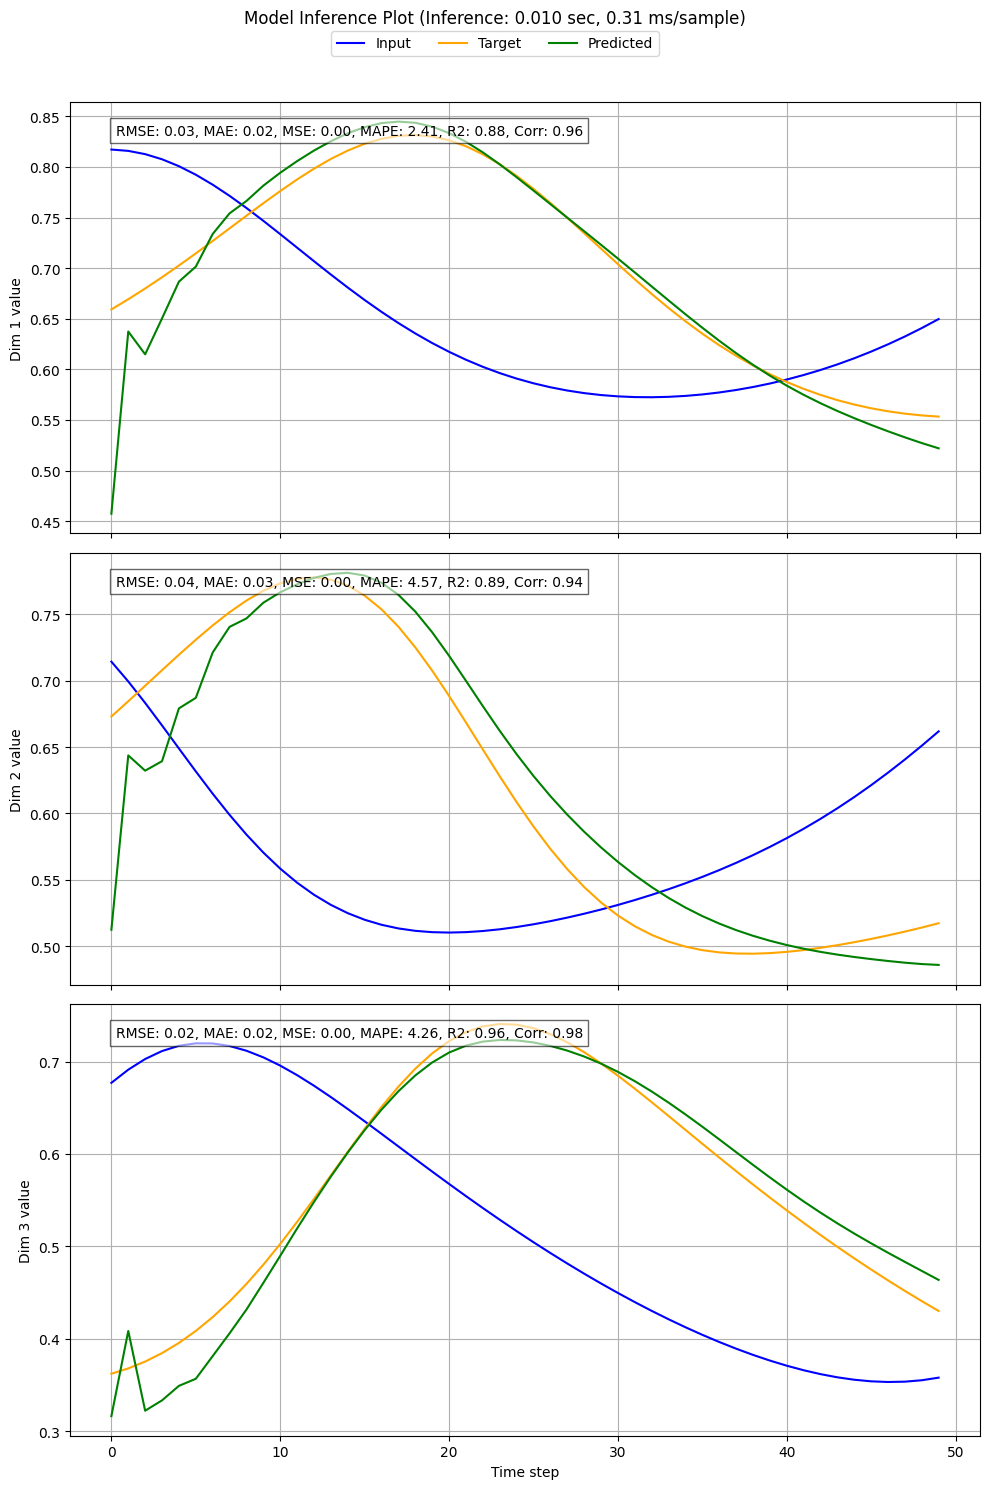

In [16]:
from src.models.ltcn import LTCModel
from src.utils.plot_utils import plot_multistep_evaluation

ltc_model_lorenz = LTCModel(
    input_size=3,
    hidden_size=16,
    output_size=3,
    ltc_cell_kwargs={
        "mapping_type": MappingType.Identity,
        "solver": ODESolver.SemiImplicit,
        "ode_solver_unfolds": 1,
        "w_init_min": 0.01,
        "w_init_max": 0.01,
        "cm_init_min": 0.5,
        "cm_init_max": 0.5,
        "gleak_init_min": 1.0,
        "gleak_init_max": 1.0,
        "erev_init_factor": 1.0,
    },
)

train(
    model=ltc_model_lorenz,
    train_loader=lorenz_train_loader,
    test_loader=lorenz_test_loader,
    num_epochs=50,
    lr=1e-3,
    clip_params=True,
    log_dir="logs/ltc_lorenz_multistep",
    model_save_path="models/ltc_lorenz_multistep",
)

plot_multistep_evaluation(model=ltc_model_lorenz, data=lorenz_test_loader)

#### Experiment n°2: Training on a EMG Signal


Training Multi-Step:  20%|██        | 1/5 [00:52<03:28, 52.02s/it]

Epoch 1/5 | Train Loss: 0.0051 | Test Loss: 0.0007


Training Multi-Step:  40%|████      | 2/5 [01:43<02:35, 51.91s/it]

Epoch 2/5 | Train Loss: 0.0006 | Test Loss: 0.0007


Training Multi-Step:  60%|██████    | 3/5 [02:36<01:44, 52.42s/it]

Epoch 3/5 | Train Loss: 0.0006 | Test Loss: 0.0007


Training Multi-Step:  80%|████████  | 4/5 [03:27<00:51, 51.84s/it]

Epoch 4/5 | Train Loss: 0.0006 | Test Loss: 0.0007


Training Multi-Step: 100%|██████████| 5/5 [04:18<00:00, 51.78s/it]

Epoch 5/5 | Train Loss: 0.0006 | Test Loss: 0.0006


Model saved to models/emg_raw_epoch_5_train_0.0006_test_0.0006.pt


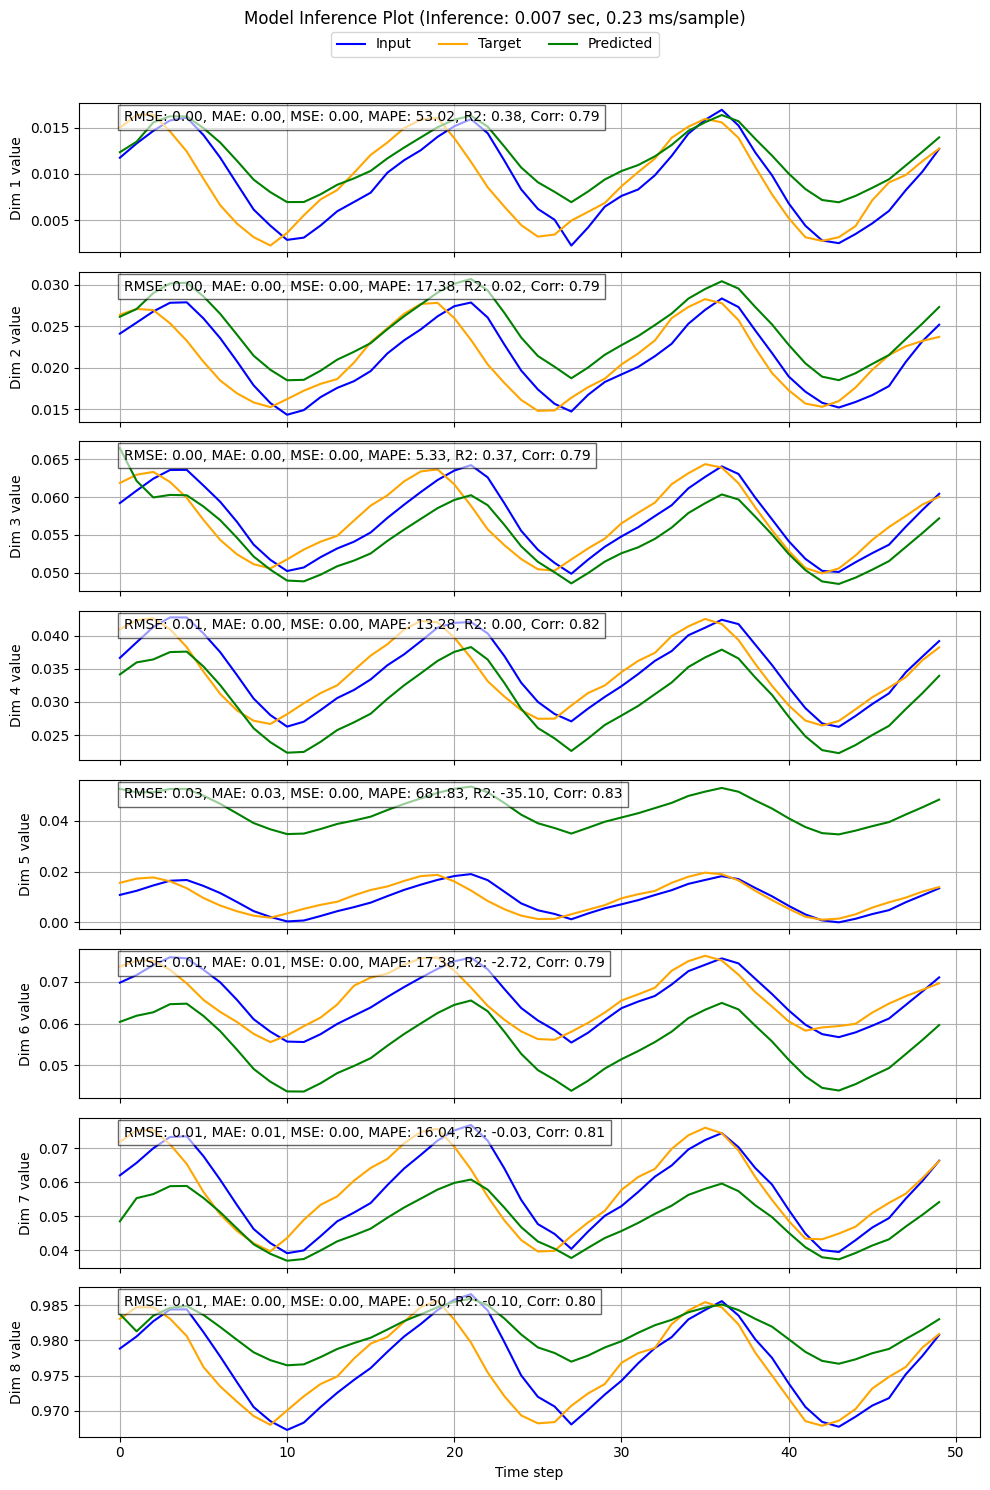

In [17]:
ltc_model_emg_raw = LTCModel(
    input_size=num_channels,
    hidden_size=16,
    output_size=num_channels,
    ltc_cell_kwargs={
        "mapping_type": MappingType.Identity,
        "solver": ODESolver.SemiImplicit,
        "ode_solver_unfolds": 1,
        "w_init_min": 0.01,
        "w_init_max": 0.01,
        "cm_init_min": 0.5,
        "cm_init_max": 0.5,
        "gleak_init_min": 1.0,
        "gleak_init_max": 1.0,
        "erev_init_factor": 1.0,
    },
)

train(
    model=ltc_model_emg_raw,
    train_loader=emg_raw_train_loader,
    test_loader=emg_raw_test_loader,
    num_epochs=5,
    lr=1e-3,
    clip_params=True,
    log_dir="logs/emg_raw",
    model_save_path="models/emg_raw",
)

plot_multistep_evaluation(model=ltc_model_emg_raw, data=emg_raw_test_loader)

Training Multi-Step:  10%|█         | 2/20 [01:44<15:42, 52.37s/it]

Epoch 2/20 | Train Loss: 0.0006 | Test Loss: 0.0007


Training Multi-Step:  20%|██        | 4/20 [03:28<13:51, 51.94s/it]

Epoch 4/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  30%|███       | 6/20 [05:12<12:08, 52.01s/it]

Epoch 6/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  40%|████      | 8/20 [06:56<10:25, 52.09s/it]

Epoch 8/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  50%|█████     | 10/20 [08:40<08:40, 52.02s/it]

Epoch 10/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  60%|██████    | 12/20 [10:24<06:55, 51.98s/it]

Epoch 12/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  70%|███████   | 14/20 [12:08<05:11, 51.94s/it]

Epoch 14/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  80%|████████  | 16/20 [13:52<03:27, 51.98s/it]

Epoch 16/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  90%|█████████ | 18/20 [15:36<01:44, 52.07s/it]

Epoch 18/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step: 100%|██████████| 20/20 [17:21<00:00, 52.08s/it]

Epoch 20/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Model saved to models/emg_raw_epoch_20_train_0.0006_test_0.0006.pt


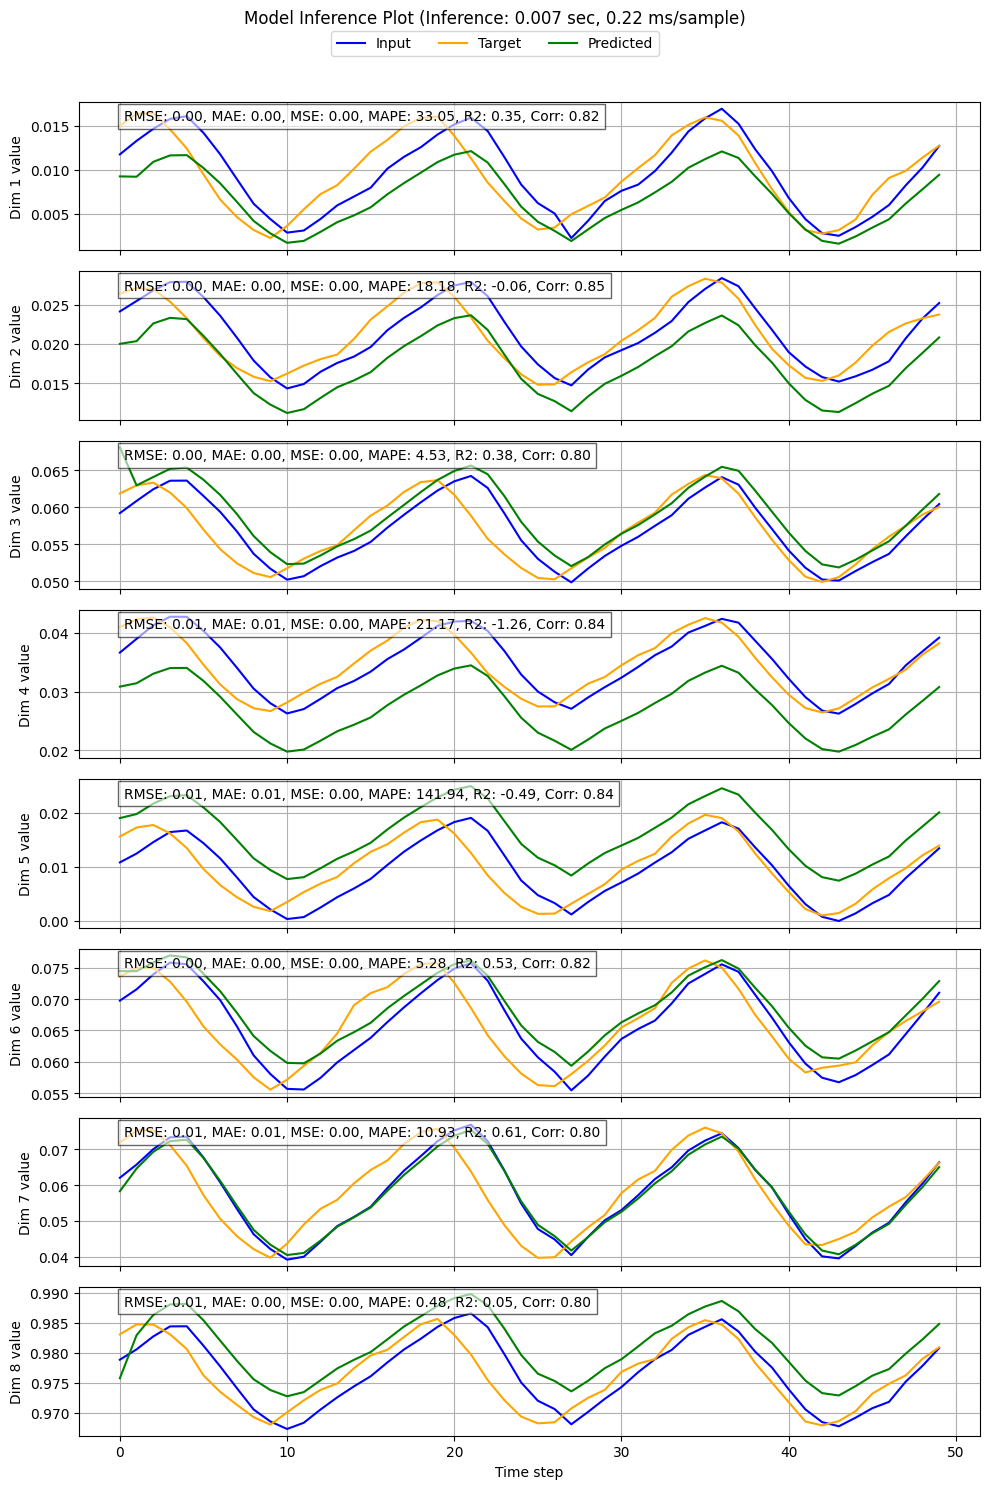

In [18]:
ltc_model_emg_raw = LTCModel(
    input_size=num_channels,
    hidden_size=16,
    output_size=num_channels,
    ltc_cell_kwargs={
        "mapping_type": MappingType.Identity,
        "solver": ODESolver.SemiImplicit,
        "ode_solver_unfolds": 1,
        "w_init_min": 0.01,
        "w_init_max": 0.01,
        "cm_init_min": 0.5,
        "cm_init_max": 0.5,
        "gleak_init_min": 1.0,
        "gleak_init_max": 1.0,
        "erev_init_factor": 1.0,
    },
)

train(
    model=ltc_model_emg_raw,
    train_loader=emg_raw_train_loader,
    test_loader=emg_raw_test_loader,
    num_epochs=20,
    lr=1e-3,
    clip_params=True,
    log_dir="logs/emg_raw",
    model_save_path="models/emg_raw",
)

plot_multistep_evaluation(model=ltc_model_emg_raw, data=emg_raw_test_loader)

Training Multi-Step:  10%|█         | 2/20 [01:45<15:47, 52.61s/it]

Epoch 2/20 | Train Loss: 0.0007 | Test Loss: 0.0007


Training Multi-Step:  20%|██        | 4/20 [03:28<13:51, 51.98s/it]

Epoch 4/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  30%|███       | 6/20 [05:12<12:04, 51.76s/it]

Epoch 6/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  40%|████      | 8/20 [06:54<10:18, 51.56s/it]

Epoch 8/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  50%|█████     | 10/20 [08:37<08:35, 51.57s/it]

Epoch 10/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  60%|██████    | 12/20 [10:21<06:52, 51.57s/it]

Epoch 12/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  70%|███████   | 14/20 [12:04<05:10, 51.69s/it]

Epoch 14/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  80%|████████  | 16/20 [13:47<03:26, 51.57s/it]

Epoch 16/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  90%|█████████ | 18/20 [15:32<01:43, 51.99s/it]

Epoch 18/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step: 100%|██████████| 20/20 [17:19<00:00, 51.97s/it]

Epoch 20/20 | Train Loss: 0.0006 | Test Loss: 0.0006
Model saved to models/emg_raw_epoch_20_train_0.0006_test_0.0006.pt


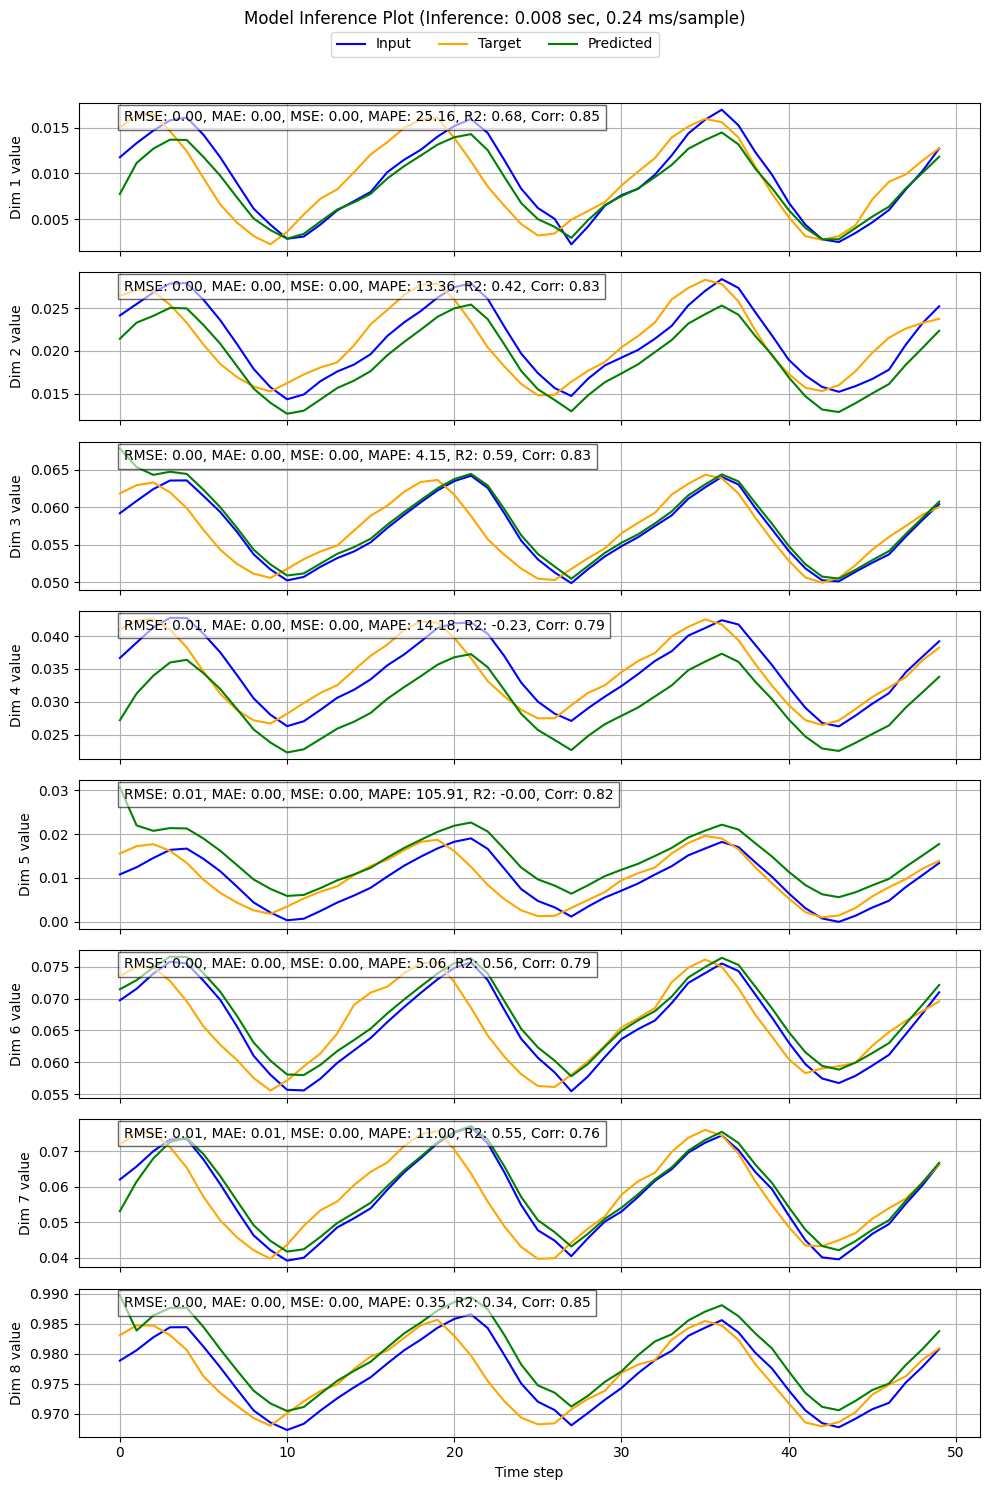

In [19]:
ltc_model_emg_raw = LTCModel(
    input_size=num_channels,
    hidden_size=32,
    output_size=num_channels,
    ltc_cell_kwargs={
        "mapping_type": MappingType.Identity,
        "solver": ODESolver.SemiImplicit,
        "ode_solver_unfolds": 1,
        "w_init_min": 0.01,
        "w_init_max": 0.01,
        "cm_init_min": 0.5,
        "cm_init_max": 0.5,
        "gleak_init_min": 1.0,
        "gleak_init_max": 1.0,
        "erev_init_factor": 1.0,
    },
)

train(
    model=ltc_model_emg_raw,
    train_loader=emg_raw_train_loader,
    test_loader=emg_raw_test_loader,
    num_epochs=20,
    lr=1e-3,
    clip_params=True,
    log_dir="logs/emg_raw",
    model_save_path="models/emg_raw",
)

plot_multistep_evaluation(model=ltc_model_emg_raw, data=emg_raw_test_loader)

Training Multi-Step:  10%|█         | 2/20 [01:46<15:56, 53.11s/it]

Epoch 2/20 | Train Loss: 0.0007 | Test Loss: 0.0007


Training Multi-Step:  20%|██        | 4/20 [03:31<14:05, 52.84s/it]

Epoch 4/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  30%|███       | 6/20 [05:18<12:23, 53.09s/it]

Epoch 6/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  40%|████      | 8/20 [07:05<10:41, 53.50s/it]

Epoch 8/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  50%|█████     | 10/20 [08:51<08:51, 53.12s/it]

Epoch 10/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  60%|██████    | 12/20 [10:36<07:03, 52.92s/it]

Epoch 12/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  70%|███████   | 14/20 [12:20<05:14, 52.39s/it]

Epoch 14/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  80%|████████  | 16/20 [14:05<03:29, 52.48s/it]

Epoch 16/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step:  90%|█████████ | 18/20 [15:49<01:44, 52.21s/it]

Epoch 18/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Training Multi-Step: 100%|██████████| 20/20 [17:35<00:00, 52.79s/it]

Epoch 20/20 | Train Loss: 0.0006 | Test Loss: 0.0006


Model saved to models/emg_raw_epoch_20_train_0.0006_test_0.0006.pt


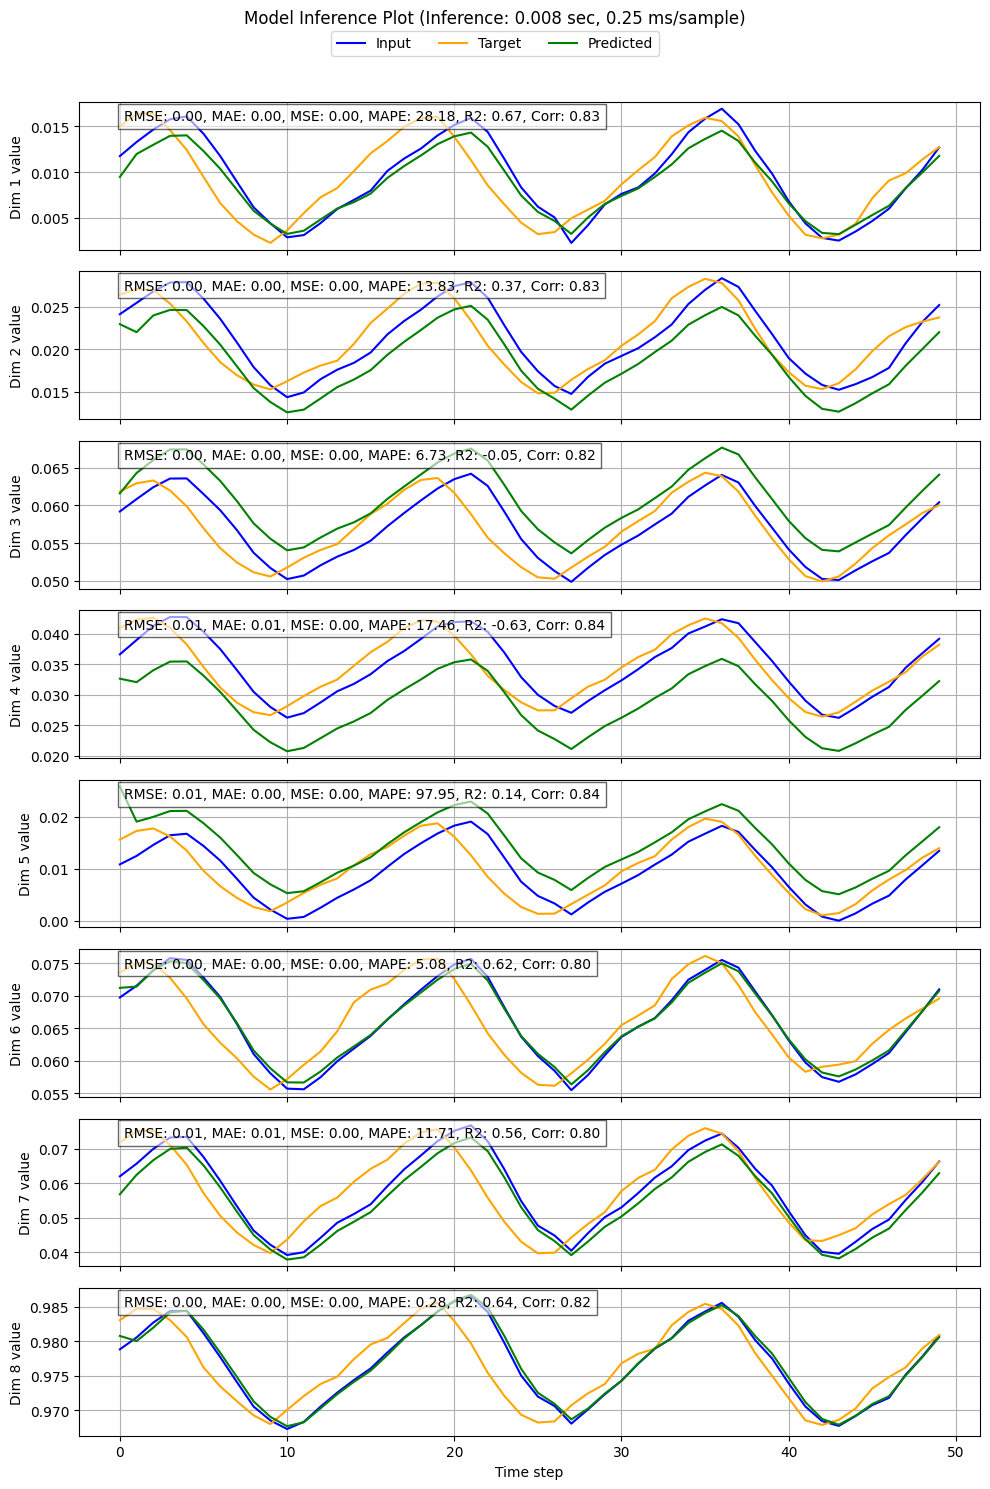

In [21]:
ltc_model_emg_raw = LTCModel(
    input_size=num_channels,
    hidden_size=32,
    output_size=num_channels,
    ltc_cell_kwargs={
        "mapping_type": MappingType.Identity,
        "solver": ODESolver.SemiImplicit,
        "ode_solver_unfolds": 1,
        "w_init_min": 0.01,
        "w_init_max": 0.05,
        "cm_init_min": 0.5,
        "cm_init_max": 0.5,
        "gleak_init_min": 1.0,
        "gleak_init_max": 1.0,
        "erev_init_factor": 1.0,
    },
)

train(
    model=ltc_model_emg_raw,
    train_loader=emg_raw_train_loader,
    test_loader=emg_raw_test_loader,
    num_epochs=20,
    lr=1e-3,
    clip_params=True,
    log_dir="logs/emg_raw",
    model_save_path="models/emg_raw",
)

plot_multistep_evaluation(model=ltc_model_emg_raw, data=emg_raw_test_loader)

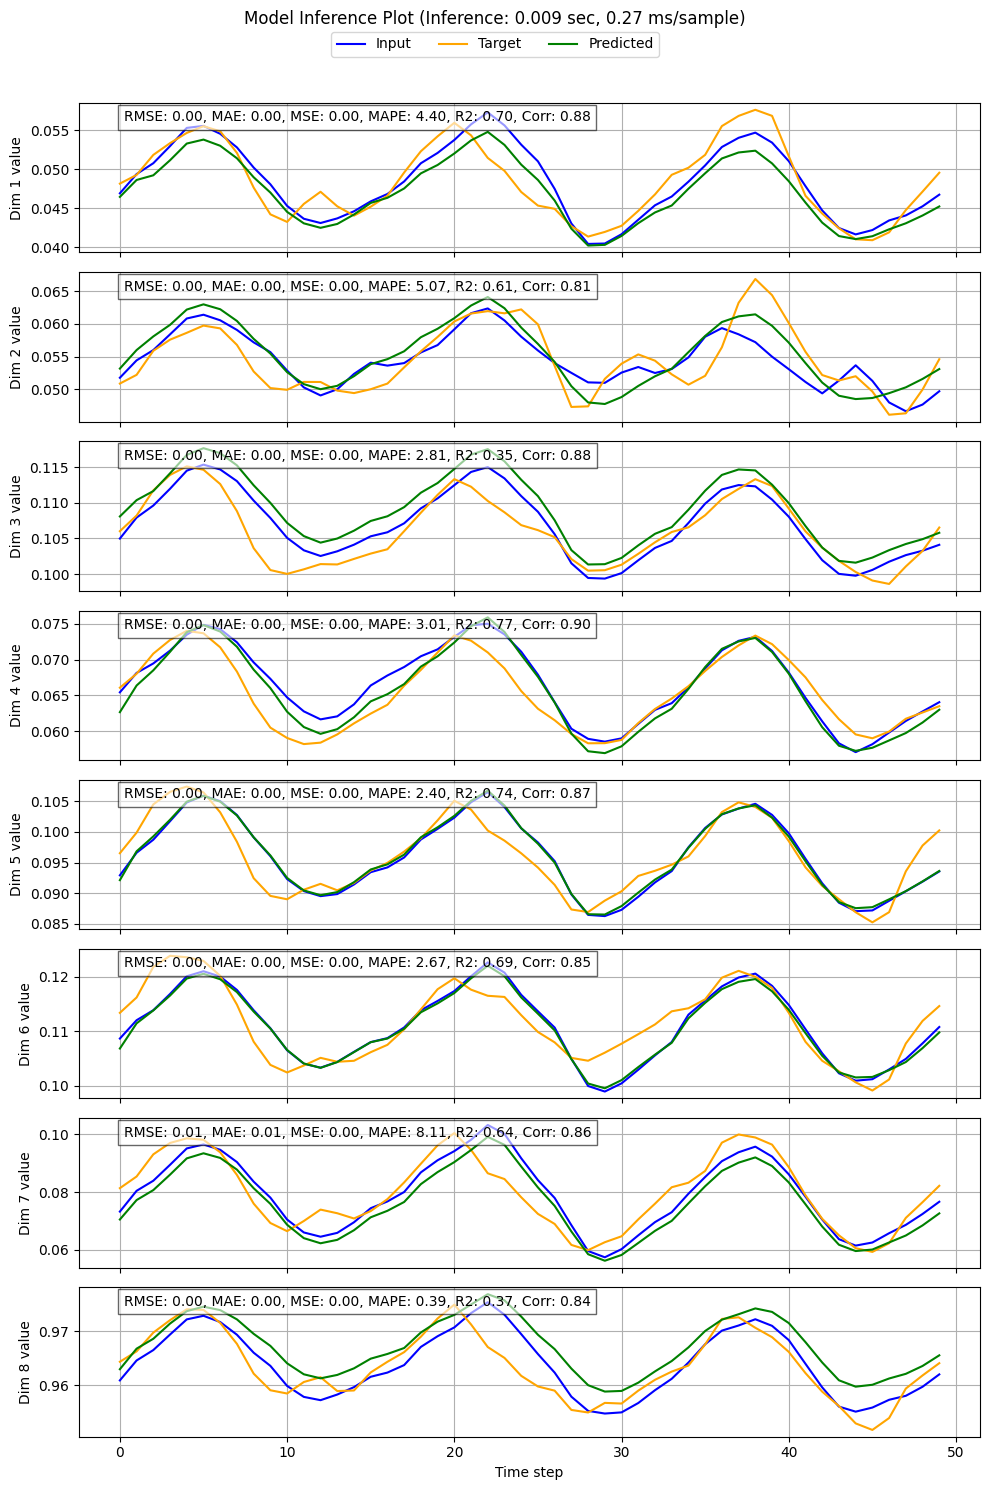

In [24]:
plot_multistep_evaluation(model=ltc_model_emg_raw, data=emg_raw_test_loader, sample_idx=15)